In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf

# Define the ticker symbol
ticker_symbol = "RELIANCE.NS"

# Create a ticker object
ticker = yf.Ticker(ticker_symbol)

# Download historical data
historical_data = ticker.history(start="2000-01-01", end="2022-12-31", interval='1d')
#historical_data = ticker.history(period="1020d", interval='1h')

In [ ]:
!pip install pandas

In [ ]:
!pip install numexpr

In [ ]:
!pip install numexpr==2.7.0

In [ ]:
import yfinance as yf

# Define the ticker symbol
ticker_symbol = "RELIANCE.NS"

# Create a ticker object
ticker = yf.Ticker(ticker_symbol)

# Download historical data
historical_data = ticker.history(start="2000-01-01", end="2022-12-31", interval='1d')

In [ ]:
len(historical_data)

In [ ]:
historical_data

In [30]:
import pandas as pd
df = pd.read_csv("RELIANCE.NS.csv")
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6941,2023-07-28,2512.050049,2542.850098,2500.550049,2527.850098,2527.850098,10413926.0
6942,2023-07-31,2527.850098,2553.899902,2517.949951,2549.250000,2549.250000,4275587.0
6943,2023-08-01,2555.000000,2559.000000,2505.300049,2513.199951,2513.199951,4768316.0
6944,2023-08-02,2509.199951,2512.000000,2463.600098,2486.350098,2486.350098,6374107.0
6945,2023-08-03,2475.300049,2500.899902,2458.050049,2475.899902,2475.899902,5084175.0


In [31]:
#Check if any zero volumes are available
indexZeros = df[ df['Volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["Volume"] == 0 )]
df.isna().sum()

Date          0
Open         10
High         10
Low          10
Close        10
Adj Close    10
Volume       10
dtype: int64

In [ ]:
! pip install pandas-ta

In [32]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [33]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
6941,2023-07-28,2512.050049,2542.850098,2500.550049,2527.850098,2527.850098,10413926.0,55.903813,43.020202,2521.700074,2581.683752,2497.971262,2462.486884,0.195571,3.414000,-1.319804,-4.249275,0.613306
6942,2023-07-31,2527.850098,2553.899902,2517.949951,2549.250000,2549.250000,4275587.0,54.906120,45.365362,2535.924926,2583.833752,2500.698761,2461.605946,0.485465,3.375071,-1.200205,8.694284,1.513854
6943,2023-08-01,2555.000000,2559.000000,2505.300049,2513.199951,2513.199951,4768316.0,54.845812,42.213402,2532.150024,2585.283752,2502.970636,2460.747821,0.992536,3.133411,-1.061893,7.577860,1.030470
6944,2023-08-02,2509.199951,2512.000000,2463.600098,2486.350098,2486.350098,6374107.0,54.583514,39.985094,2487.800049,2585.511255,2504.976886,2459.729697,1.186323,2.799643,-0.984910,-2.066424,-0.051582
6945,2023-08-03,2475.300049,2500.899902,2458.050049,2475.899902,2475.899902,5084175.0,53.996831,39.119556,2479.474976,2585.425000,2506.657510,2458.897195,1.110929,2.429768,-0.911696,-7.945717,-0.507400


In [34]:
#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [35]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
0,1996-01-01,15.859429,15.944529,15.754989,15.917452,10.477990,48051995.0,NaN,NaN,15.849759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1996-01-02,15.878770,15.956133,15.677626,15.793671,10.396508,77875009.0,NaN,NaN,15.816879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1996-01-03,16.052837,16.783918,15.878770,15.913584,10.475445,96602936.0,NaN,NaN,16.331344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,1996-01-04,15.762726,15.813012,15.553845,15.766594,10.378684,100099436.0,NaN,NaN,15.683429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1996-01-05,15.704703,15.704703,15.522900,15.658285,10.307390,76935930.0,NaN,NaN,15.613802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


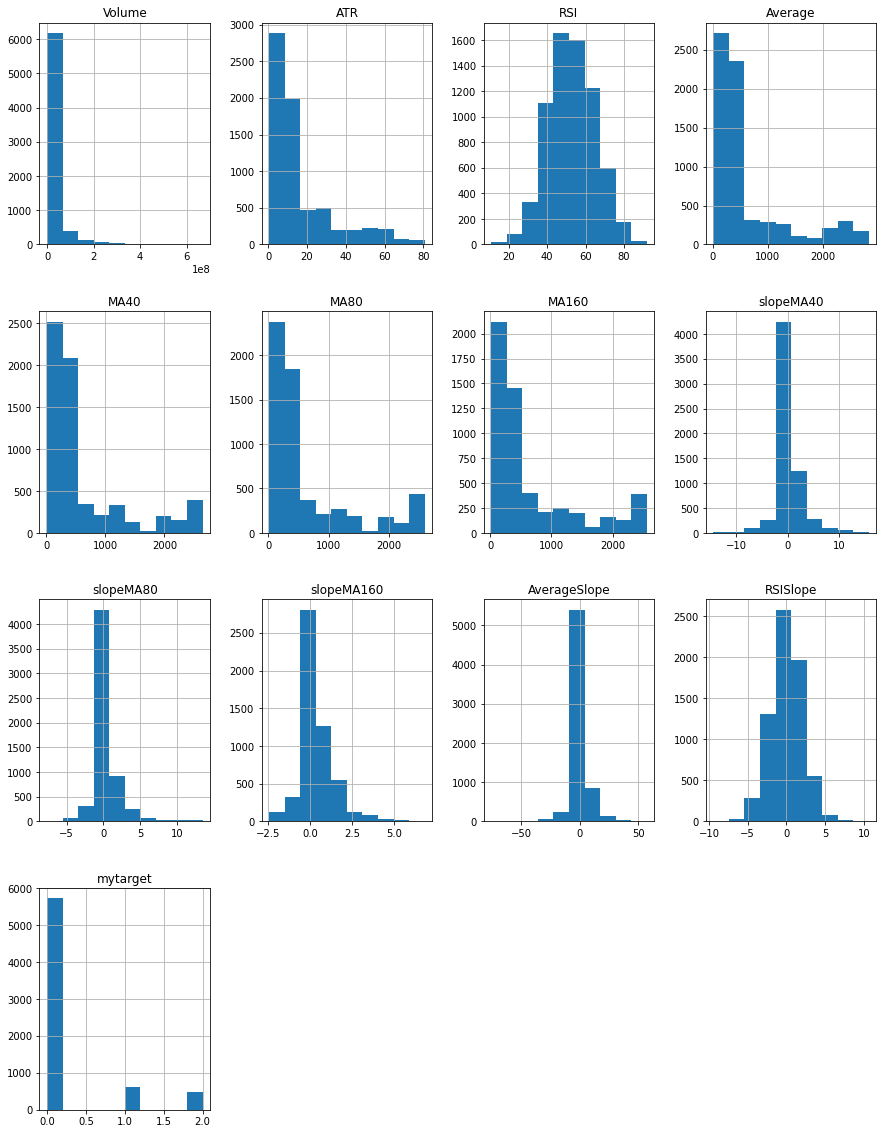

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

## RSI as an Indicator how is it?

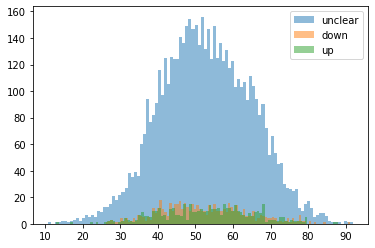

In [39]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

In [40]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

            ATR        RSI      Average         MA40         MA80  \
170    0.728075  50.104236    16.315871    15.920063    17.194909   
171    0.708107  48.689203    16.101190    15.917742    17.158114   
172    0.696682  53.512960    16.313937    15.935149    17.124026   
173    0.675576  51.707787    16.453190    15.975184    17.086698   
174    0.649916  51.882594    16.335213    16.016960    17.055462   
...         ...        ...          ...          ...          ...   
6923  36.139135  62.032817  2599.125000  2499.737506  2414.261261   
6924  35.992176  61.141239  2592.400024  2502.552509  2416.750012   
6925  37.612562  67.552142  2610.250000  2506.532507  2419.625638   
6926  37.579432  66.431699  2646.474976  2509.957507  2422.328763   
6927  41.820455  75.169073  2715.500000  2516.326257  2427.026263   

            MA160  slopeMA40  slopeMA80  slopeMA160  AverageSlope  RSISlope  
170     16.842400  -0.012016  -0.046162    0.002328      0.217722  2.431927  
171     16.8488

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [42]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [43]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 84.88%
Accuracy test: 83.85%
0.0    84.676056
1.0     8.713615
2.0     6.610329
Name: mytarget, dtype: float64
Accuracy Gambler: 31.92%


In [47]:
!pip install xgboost

In [48]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 98.2394%
****Test Results****
Accuracy: 83.6620%


In [49]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 98.3568%
****Test Results****
Accuracy: 87.8873%


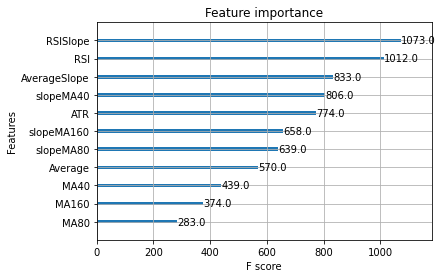

In [50]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()